In [1]:
import os
import math
import numpy as np
import torch
import torch.nn.functional as F
import Pk_library as PKL
import scipy.ndimage
import imageio
import matplotlib.pyplot as plt

import utilities
import flow_architecture
import losses

In [2]:
device = 'cuda'
float_dtype = np.float32
torch.set_default_tensor_type(torch.cuda.FloatTensor)
device_id = 2
torch.cuda.set_device(device_id)

In [3]:
save_dir = "nbody_384px_mask_1p0_wf/"
if not os.path.exists(save_dir): os.makedirs(save_dir)

In [4]:
cl_theo_ell = np.load('sample_test_data/384px_cl_theo_ell.npy')
cl_theo = np.load('sample_test_data/384px_cl_theo.npy')

In [5]:
class Parameters():
    def __init__(self):
        #Data parameters
        self.nx = 384
        self.dx = 0.00018425707547169813
        
        #Fitting parameters
        self.nlev_t = 1.0
        self.noise_fac = self.nlev_t
        self.noise_pix = 2*(self.nlev_t)**2
        self.use_ql = False #The nbody power spectrum is matched with trainingdata
        self.wf_batch_size = 1 #The number of maps to fit
        
        mask512 = (imageio.imread("masks/mask2_512.png")[19:485, 19:485, 0]/255).astype(float)
        self.mask = scipy.ndimage.zoom(mask512, 384/(485-19), order=0)
        
        #Pre-trained flow parameters
        self.flow_n_layers = 16
        self.flow_hidden = [12, 12]
        self.trained_flow_dir = 'pretrained_flows/'
        
params = Parameters()

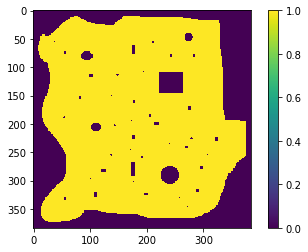

In [6]:
plt.imshow(params.mask)
plt.colorbar()

In [7]:
prior = flow_architecture.SimpleNormal(torch.zeros((params.nx, params.nx)), torch.ones((params.nx, params.nx)))

layers = flow_architecture.make_flow1_affine_layers(lattice_shape=(params.nx, params.nx),
                                                    n_layers=params.flow_n_layers, hidden_sizes=params.flow_hidden,
                                                    kernel_size=[3, 3, 3], torch_device=device, padding_mode='zeros')
model = {'layers': layers, 'prior': prior}

checkpoint = torch.load(params.trained_flow_dir+'dict_nonperiodic')
model['layers'].load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [8]:
y_true_np = np.load('sample_test_data/384px_true_map.npy')
y_true_np = (y_true_np - np.mean(y_true_np)) / np.std(y_true_np)
np.save(save_dir + '/true_maps', y_true_np)

y_pred_np = utilities.add_noise(y_true_np, std=params.noise_fac) * params.mask
np.save(save_dir + '/masked_maps', y_pred_np)

In [9]:
vmin = np.min(y_true_np)
vmax = 11
figsize = (6, 6)

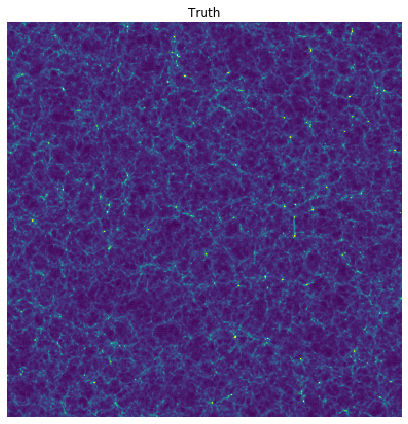

In [10]:
utilities.imshow(y_true_np[0], vmin=vmin, vmax=vmax, title='Truth', figsize=figsize, axis=False, colorbar=False, file_name=save_dir+'/truth')

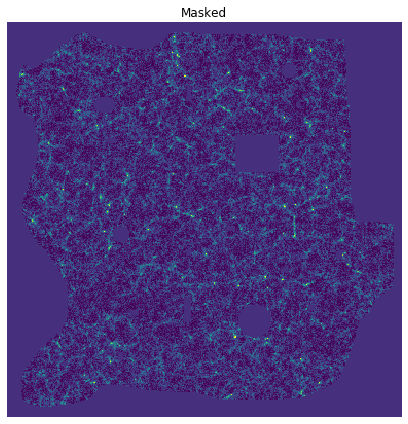

In [11]:
utilities.imshow(y_pred_np[0], vmin=vmin, vmax=vmax, title='Masked', figsize=figsize, axis=False, colorbar=False, file_name=save_dir+'/masked')

In [12]:
y_true        = torch.tensor(y_true_np, requires_grad=True,  dtype=torch.float32).to(device)
y_pred_nograd = torch.tensor(y_pred_np, requires_grad=False, dtype=torch.float32).to(device)
y_pred_wf = [None] * params.wf_batch_size
for n in range(params.wf_batch_size):
    y_pred_wf[n] = torch.tensor(np.expand_dims(y_pred_np[n], 0), requires_grad=True,  dtype=torch.float32).to(device)

In [13]:
lossfunctions = losses.Lossfunctions(params, cl_theo_ell=cl_theo_ell, cl_theo=cl_theo)

In [14]:
loss_list_wf = []
J2_ave_list_wf = []
J2_map_list_wf = [None] * params.wf_batch_size

In [15]:
def optimize(y_pred_nograd, y_pred, optimizer, steps, loss_list, J2_ave_list, J2_map_list, use_flow, print_freq=100):
    for i in range(steps):
        loss_ave = 0
        J2_ave = 0
        
        for n in range(1):
            optimizer[n].zero_grad()
            if use_flow:
                loss_1, loss_2 = lossfunctions.loss_wiener_J3_flow(y_pred_nograd[n], y_pred[n], prior, model['layers'])
            else:
                loss_1, loss_2 = lossfunctions.loss_wiener_J3(y_pred_nograd[n], y_pred[n])
            loss = loss_1 + loss_2
            loss.backward()
            optimizer[n].step()
            loss_ave += loss.cpu().detach().numpy() / params.wf_batch_size
            #J2_map_list[n] = lossfunctions.loss_J2(y_true[n], y_pred[n]).cpu().detach().numpy()
            #J2_ave += J2_map_list[n] / params.wf_batch_size
            
            
        loss_list.append(loss_ave)
        #J2_ave_list.append(J2_ave)
        if i % print_freq == 0: print("step =", i, "loss =", loss_ave, "J2 =", J2_ave)

## Weiner filtering

In [16]:
optimizer_wf = []
for n in range(params.wf_batch_size):
    optimizer_wf.append(torch.optim.Adam([y_pred_wf[n]], lr=0.01))

In [17]:
optimize(y_pred_nograd, y_pred_wf, optimizer_wf, 8000, loss_list_wf, J2_ave_list_wf, J2_map_list_wf, False)

step = 0 loss = [367064.33106892] J2 = 0
step = 100 loss = [92372.22295347] J2 = 0
step = 200 loss = [62980.40096267] J2 = 0
step = 300 loss = [56413.18792098] J2 = 0
step = 400 loss = [54208.59407199] J2 = 0
step = 500 loss = [53278.20798826] J2 = 0
step = 600 loss = [52820.96361214] J2 = 0
step = 700 loss = [52569.24271244] J2 = 0
step = 800 loss = [52418.21831364] J2 = 0
step = 900 loss = [52321.79795429] J2 = 0
step = 1000 loss = [52257.64468288] J2 = 0
step = 1100 loss = [52213.90395212] J2 = 0
step = 1200 loss = [52183.71856934] J2 = 0
step = 1300 loss = [52162.81384227] J2 = 0
step = 1400 loss = [52148.36791059] J2 = 0
step = 1500 loss = [52138.44095046] J2 = 0
step = 1600 loss = [52132.57911889] J2 = 0
step = 1700 loss = [52127.10610848] J2 = 0
step = 1800 loss = [52124.05266117] J2 = 0
step = 1900 loss = [52122.03797694] J2 = 0
step = 2000 loss = [52120.71506671] J2 = 0
step = 2100 loss = [52119.86409546] J2 = 0
step = 2200 loss = [52119.32130394] J2 = 0
step = 2300 loss = [52

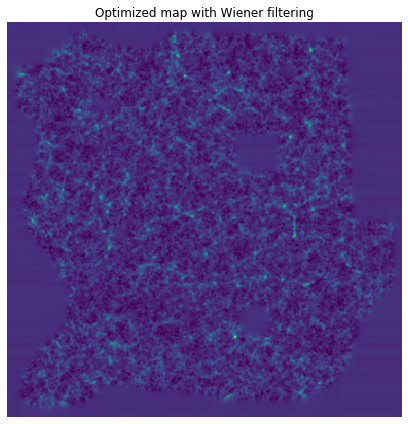

In [18]:
y_pred_wf_np = y_pred_wf[0].cpu().detach().numpy()
utilities.imshow(y_pred_wf_np[0], title='Optimized map with Wiener filtering',
                 vmin=vmin, vmax=vmax, figsize=figsize, axis=False, colorbar=False, file_name=save_dir+'/wf_result')

In [19]:
np.save(save_dir+'/y_pred_wf_np', y_pred_wf_np)

In [20]:
y_pred_wf_cc = torch.zeros((params.wf_batch_size, params.nx, params.nx))
for n in range(params.wf_batch_size):
    y_pred_wf_cc[n, :, :] = y_pred_wf[n]

In [21]:
y_pred_wf_cc_np = utilities.grab(y_pred_wf_cc)
np.save(save_dir + '/wf_maps', y_pred_wf_cc_np)